## W08 - Embeddings

So far, we have only seen word embeddings. Word embeddings can be extended to sentence and document embedding by averaging the word embeddings. But, this method is not as robust as other options. 

In this notbook we will use OpenAI's embedding api to embed sentences and documents. The data we will analyze is extracted from StackOverflow. The data consists of 2000 questions and answers from the topic of Python, HTML, r, and CSS.


In [1]:
# import modules

import pandas as pd
import numpy as np
import openai
import tiktoken
import pyarrow

import matplotlib.pyplot as plt
import mplcursors

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# notice that you will need to install certain packages to make this work (ipympl)
%matplotlib ipympl
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) # read local .env file

# Initialize the GPT-3.5-turbo API client
# NOTE: Notebook may need to be restarted after you update the API key
#      for the new key to take effect. This is because a module once
#      loaded will not be reloaded even if you change the key in the
#      keys.py file. To force a reload, you must restart the notebook.
openai.api_key = os.environ['OPENAI_API_KEY']




In [2]:
# load file
df = pd.read_csv('data/so_database_app.csv')
df.head()

,input_text,output_text,category,ada2_input_embedding
0,"python's inspect.getfile returns ""<string>""<p>...",<p><code>&lt;string&gt;</code> means that the ...,python,"[-0.011460098437964916, 0.012179410085082054, ..."
1,Passing parameter to function while multithrea...,<p>Try this and note the difference:</p>\n<pre...,python,"[-0.028142772614955902, 0.01403122115880251, 0..."
2,How do we test a specific method written in a ...,"<p>Duplicate of <a href=""https://stackoverflow...",python,"[0.0035385016817599535, -0.008937591686844826,..."
3,how can i remove the black bg color of an imag...,<p>The alpha channel &quot;disappears&quot; be...,python,"[-0.0015521121677011251, -0.00932104978710413,..."
4,How to extract each sheet within an Excel file...,<p>You need to specify the <code>index</code> ...,python,"[-0.013369491323828697, 0.014619970694184303, ..."


## 1.0 Create Embeddings

There many pretrained models available that will create document embeddings. One popular one is OpenAI's text-embedding-ada-002. This model is trained on a large corpus of text from the internet. 

> The following code will make 2,000 calls to OpenAI text-embedding-ada-002. Each of these calls is $0.0001 per 1,000 tokens. Assuming that each stackoverflow question is 4000 tokens, this will cost $0.80.
> 
>  I have already done this for you, and saved the file as a a parquet file. I have included the code so that you can see how these embeddings are generated, but you should simply load the parquet file where I have stored the embedding results.

In [3]:
#def get_embedding(text, model="text-embedding-ada-002"):
#   text = text.replace("\n", " ")
#   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

#enc = tiktoken.get_encoding('cl100k_base') # this is the tokenizer for the model text-embedding-ada-002
#def encode(text):    
#    encoding = enc.encode(text)
#    if len(encoding) < 1024*8:
#        return get_embedding(text, model='text-embedding-ada-002')
#    else:
#        return get_embedding(text[:1014*8], model='text-embedding-ada-002') 

#df['ada2_input_embedding'] = df['input_text'].apply(lambda x: encode(x))
#df.to_parquet('data/so_database_with_input_embedding.parquet', engine = 'pyarrow', compression = 'gzip')

df = pd.read_parquet('data/so_database_with_input_embedding.parquet', engine = 'pyarrow')

## 2.0 Explore Embedding Space

In this section we will explore the embedding space created by the text-embedding-ada-002 model. 

### 2.1 Reduce Dimensionality of the embedding vectors to 3 dimensions

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)

X = np.array(df['ada2_input_embedding'].tolist())
pca.fit(X)
X = pca.transform(X)
df['pca1'] = X[:,0]
df['pca2'] = X[:,1]
df['pca3'] = X[:,2]


#### 2.2 Create a 3D plot of the embeddings

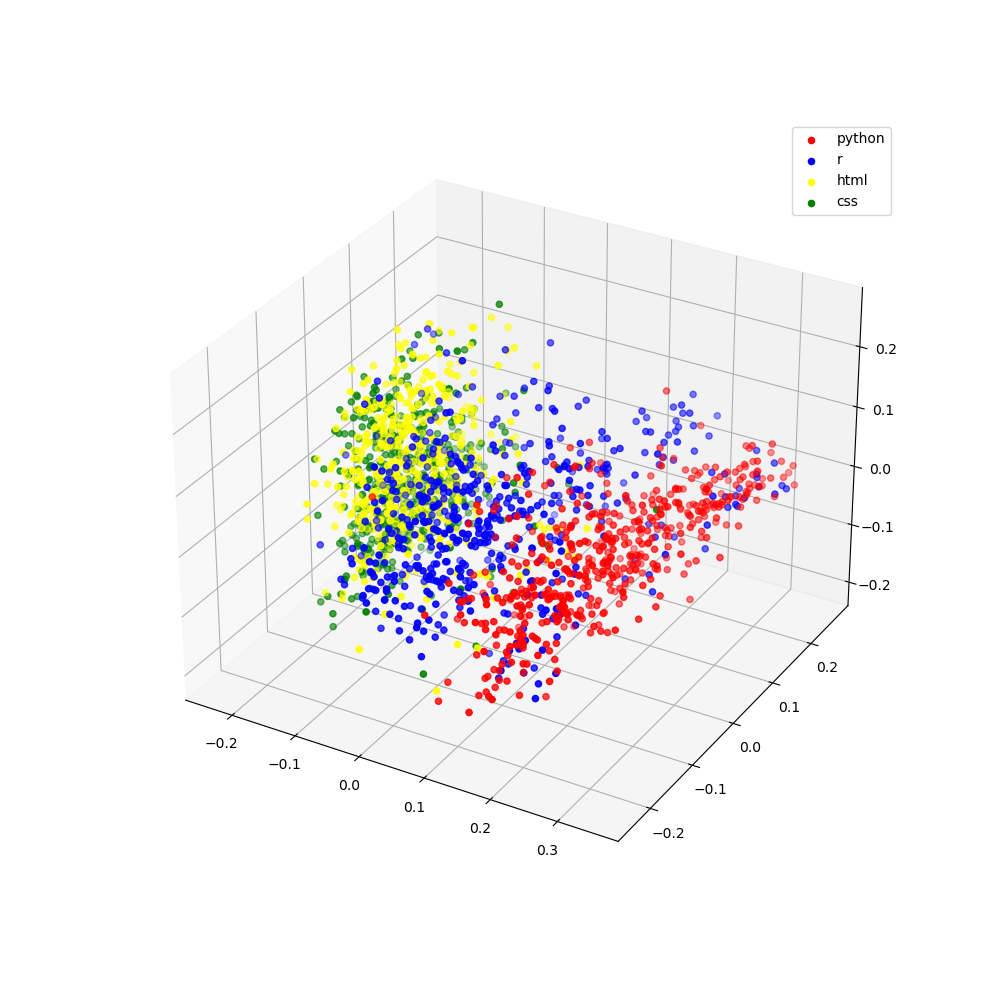

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(df[df['category']=='python'].pca1, df[df['category']=='python'].pca2, df[df['category']=='python'].pca3, label='python', c='red')
ax.scatter(df[df['category']=='r'].pca1, df[df['category']=='r'].pca2, df[df['category']=='r'].pca3, label='r', c='blue')
ax.scatter(df[df['category']=='html'].pca1, df[df['category']=='html'].pca2, df[df['category']=='html'].pca3, label='html', c='yellow')
ax.scatter(df[df['category']=='css'].pca1, df[df['category']=='css'].pca2, df[df['category']=='css'].pca3, label='css', c='green')

ax.legend()
#fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
#fig.show()

## 3.0 Clustering of Embeddings

In this section we use kmeans clustering to cluster the embeddings. Since we will limit our analysis to Python and HTML, we know we have 2 categories, therefore we will use 2 clusters.

In [6]:
clustering_dataset = df[:1000].copy() # limit our analysis to python and html

In [7]:
clustering_dataset['category'].unique() # double check

array(['python', 'html'], dtype=object)

In [8]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, 
                random_state=0, 
                n_init = 'auto').fit(clustering_dataset[['pca1','pca2','pca3']])

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
def clusters_3D(df, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    for i, row in df.iterrows():
        ax.scatter(row.pca1, 
                   row.pca2, 
                   row.pca3,
                   c = row.color,
                   marker = row.marker,
                   alpha=0.5, 
                   edgecolors='black'
        )
        

    # Create a mplcursors object to manage the data point interaction
    cursor = mplcursors.cursor(hover=True)

    #axes
    ax.set_title(title)  # Add a title
    ax.set_xlabel('X_1')  # Add x-axis label
    ax.set_ylabel('X_2')  # Add y-axis label
    ax.set_zlabel('X_3')  # Add z-axis label

    plt.show()

In [ ]:
clustering_dataset['marker'] = clustering_dataset['category'].apply(lambda x: 'o' if x == 'python' else 's')
clustering_dataset['cluster'] = kmeans.predict(clustering_dataset[['pca1','pca2','pca3']])
clustering_dataset['color'] = clustering_dataset['cluster'].apply(lambda x: 'red' if x == 0 else 'blue')
clustering_dataset['target'] = clustering_dataset['category'].apply(lambda x: 1 if x == 'python' else 0)

clusters_3D(clustering_dataset, 
            title = 'Embedding clusters visualization in 3D'
            ) 

,input_text,output_text,category,ada2_input_embedding,pca1,pca2,pca3,marker,cluster,color,target
0,"python's inspect.getfile returns ""<string>""<p>...",<p><code>&lt;string&gt;</code> means that the ...,python,"[-0.011460098437964916, 0.012179410085082054, ...",0.174894,-0.130865,-0.083321,o,1,blue,1
1,Passing parameter to function while multithrea...,<p>Try this and note the difference:</p>\n<pre...,python,"[-0.028142772614955902, 0.01403122115880251, 0...",0.199639,-0.072621,0.045760,o,1,blue,1
2,How do we test a specific method written in a ...,"<p>Duplicate of <a href=""https://stackoverflow...",python,"[0.003777547739446163, -0.008819914422929287, ...",0.217030,-0.136316,-0.000915,o,1,blue,1
3,how can i remove the black bg color of an imag...,<p>The alpha channel &quot;disappears&quot; be...,python,"[-0.0015521121677011251, -0.00932104978710413,...",0.051548,0.000957,-0.170847,o,1,blue,1
4,How to extract each sheet within an Excel file...,<p>You need to specify the <code>index</code> ...,python,"[-0.01334470883011818, 0.014615951105952263, 0...",0.231636,0.086588,-0.024241,o,1,blue,1


#### 3.1 Evaluate the clustering performance using the ground truth (category)

In [ ]:
# consfusion matrix

from sklearn.metrics import confusion_matrix

print(confusion_matrix(clustering_dataset['target'], clustering_dataset['cluster']))

# accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(clustering_dataset['target'], clustering_dataset['cluster']))

# precision
from sklearn.metrics import precision_score
print("Precision:",precision_score(clustering_dataset['target'], clustering_dataset['cluster']))

# recall

from sklearn.metrics import recall_score

print("Recall", recall_score(clustering_dataset['target'], clustering_dataset['cluster']))

# f1


print("F1 Score", f1_score(clustering_dataset['target'], clustering_dataset['cluster']))


[[480  20]
 [  5 495]]
Accuracy: 0.975
Precision: 0.9611650485436893
Recall 0.99
F1 Score 0.9753694581280788


## 4.0 Anomoly Detection

In this section we will use the embeddings to detect anomolies. Though there are many ways to do this, we will use the cleanlab module, OutOfDistribution method.

In [ ]:
# read a fresh dataframe
df = pd.read_parquet('data/so_database_with_input_embedding.parquet', engine = 'pyarrow')

In [ ]:
### Create an 'anomoly' dataset (we create one outlier)

input_text = """Do people on reality tv shows have the right to say they don’t want to be filmed?
Been watching border security and I was wondering if those that are being filmed can say they don’t 
want to be filmed? Do they have a choice? I know they can blur out some peoples faces and I assume that’s 
the persons request. Also do people on shows like border security and Ambulance and 24hrs in A&E do they 
have to sign a release form? If so what happens if they refuse? Even if they have their faces blurred??"""

output_text = """Do people on reality tv shows have the right to say they don’t want to be filmed?"""

enc = openai.Embedding.create(input = input_text, model='text-embedding-ada-002')['data'][0]['embedding']
enc = np.array(enc)
df_enc = pd.DataFrame({'input_text': [input_text], 'output_text': [output_text], 'category': ['RealityTV'], 'ada2_input_embedding': [enc]})

df = pd.concat([df,df_enc], ignore_index = True)
df.tail()

,input_text,output_text,category,ada2_input_embedding
1996,Flip Clock code works on Codepen and doesn't w...,<p>You forgot to attach the CSS file for the f...,css,"[-0.025138702243566513, 0.028360258787870407, ..."
1997,React Native How can I put one view in front o...,<p>You can do it using zIndex for example:</p>...,css,"[0.00641911756247282, 0.019813962280750275, 0...."
1998,setting fixed width with 100% height of the pa...,<p>You can use <code>width: calc(100% - 100px)...,css,"[0.010545001365244389, 0.028665771707892418, 0..."
1999,How to make sidebar button not bring viewpoint...,"<p>It is quite simple, just remove that href=""...",css,"[-0.008182060904800892, 0.006507186219096184, ..."
2000,Do people on reality tv shows have the right t...,Do people on reality tv shows have the right t...,RealityTV,"[0.0031675079371780157, -0.02463977411389351, ..."


In [ ]:
from sklearn.ensemble import IsolationForest
from cleanlab.outlier import OutOfDistribution

embeddings_array = np.array(df.ada2_input_embedding.to_list())

ood = OutOfDistribution()
train_outlier_scores = ood.fit_score(features=embeddings_array)

top_train_outlier_idxs = (train_outlier_scores).argsort()[:10]
top_train_outlier_subset = df.iloc[top_train_outlier_idxs,]
top_train_outlier_subset

Fitting OOD estimator based on provided features ...


,input_text,output_text,category,ada2_input_embedding,anomaly
1470,Extract tags from Go struct as a reflect.Value...,<p>When you call <code>reflect.TypeOf(f)</code...,r,"[-0.032492153346538544, 0.02278478629887104, 0...",-1
1139,Chisel/FIRRTL DefnameDifferentPortsException<p...,<p>This check is supposed to disallow impossib...,r,"[-0.042731381952762604, 0.003643893403932452, ...",-1
1144,OSMnx- why is the 'walk' network larger than '...,<p>The <code>walk</code> network type is fully...,r,"[0.028290685266256332, 0.01636490225791931, 0....",-1
1426,CodeIgniter 4 \Config\Service::my-instance-met...,<p>This line of code is incorrect logically.</...,r,"[-0.01462541799992323, 0.0051501295529305935, ...",-1
164,"""return"" with Ternary and warlus operators<p>W...",<p>The comments suggest that you can't use the...,python,"[-0.009246114641427994, 0.0315314382314682, 0....",-1
1482,How to Iterate over a parameter pack<p>I need ...,<p>To use a <code>std::tuple</code> to iterate...,r,"[-0.007661641109734774, 0.0225492212921381, -0...",-1
2000,Do people on reality tv shows have the right t...,Do people on reality tv shows have the right t...,RealityTV,"[0.0031675079371780157, -0.02463977411389351, ...",1
1053,How to check that last test is failed?<p>I tes...,<p>Test functions have return values -- a true...,r,"[-0.019333040341734886, 0.013527591712772846, ...",-1
1480,Strategy: Understanding strategy.exit() and st...,<p>Use <code>strategy.exit()</code> when you w...,r,"[0.0006543453200720251, 0.008729171939194202, ...",1
1339,Why does free() of a struct result in segfault...,<p>There never was a hashtable to begin with. ...,r,"[-0.006756638642400503, 0.003308901796117425, ...",1


> NOTE: The outlier we added was detected. As we can see, a small number of other questions were also detected as outliers. 